In [39]:
import pandas as pd
import re

# Read the list of filenames from the configuration file
with open('file_list.txt', 'r', encoding='utf-8') as config_file:
    file_names = config_file.read().splitlines()

# Regex pattern to match the data format
pattern = r'\[(.*?)\] (.*?): (.*)'


# Initialize an empty list to store parsed data
datalist = []
stream_count = 0
# Iterate over each specified file
for file in file_names:
    full_path = file
    with open(full_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                date, user, message = match.groups()
                datalist.append([date, user, message,stream_count])
    stream_count = stream_count + 1

# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])

In [40]:
data['date'] = pd.to_datetime(data['date'])

data = data.sort_values(by=['user', 'date'])

In [41]:
data['first_message'] = data.groupby('user').cumcount().apply(lambda x: 1 if x == 0 else 0)

data.head(10)

,date,user,message,stream,first_message
10789,2024-05-05 16:24:24+00:00,00001joel,you ever tried snus?,4,1
12356,2024-05-05 19:53:34+00:00,00001joel,you have a boyfriend???,4,0
12361,2024-05-05 19:54:18+00:00,00001joel,:(,4,0
13132,2024-05-06 15:38:41+00:00,00001joel,whats your favourite snus!,5,0
38876,2024-05-17 18:36:08+00:00,00ramez00,my friend loves u,14,1
205726,2024-07-25 14:15:23+00:00,04lennart04,do you drink beer?,72,1
205847,2024-07-25 14:23:58+00:00,04lennart04,Malle,72,0
205862,2024-07-25 14:24:45+00:00,04lennart04,try moneyboy,72,0
104517,2024-06-11 15:38:40+00:00,062_davi,hello,37,1
158595,2024-07-06 12:45:45+00:00,082274699958,doro love greets from indonesian❤️,55,1


In [42]:
data[data['user'] == 'balintboss']

,date,user,message,stream,first_message
21,2024-05-01 15:06:18+00:00,balintboss,ready to 1984,0,1
60,2024-05-01 15:10:39+00:00,balintboss,ADHD,0,0
69,2024-05-01 15:11:14+00:00,balintboss,hell no,0,0
84,2024-05-01 15:12:31+00:00,balintboss,hike,0,0
146,2024-05-01 15:18:24+00:00,balintboss,o7,0,0
...,...,...,...,...,...
219714,2024-07-29 18:27:18+00:00,balintboss,8%,75,0
219715,2024-07-29 18:27:20+00:00,balintboss,LOL,75,0
219727,2024-07-29 18:28:09+00:00,balintboss,it was good stream o7,75,0
219744,2024-07-29 18:29:01+00:00,balintboss,bye,75,0


In [43]:
data['first_message'].describe()

count    219766.000000
mean          0.028367
std           0.166018
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: first_message, dtype: float64

In [44]:
#unique chaterrs each stream
unique_chatters_per_stream = data.groupby('stream')['user'].nunique()

In [45]:
# Calculate the number of first messages per stream
first_messages_per_stream = data.groupby('stream')['first_message'].sum()


# Calculate the total number of messages per stream
total_messages_per_stream = data['stream'].value_counts()

# Combine the results into a single DataFrame
stream_stats = pd.DataFrame({
    'first_messages': first_messages_per_stream,
    'total_messages': total_messages_per_stream,
    'unique_chatters': unique_chatters_per_stream
})


stream_stats

,first_messages,total_messages,unique_chatters
stream,,,
0,177,1985,177
1,150,3046,213
2,104,2754,185
3,84,2375,184
4,76,2455,182
...,...,...,...
71,107,3909,334
72,100,3739,325
73,106,4187,325


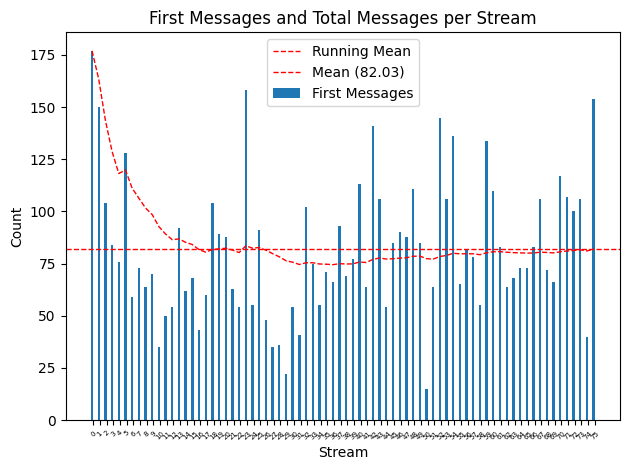

In [46]:
import matplotlib.pyplot as plt


# Plot the chart
fig, ax = plt.subplots()

# Bar width
bar_width = 0.35

# Bar positions
index = range(len(stream_stats))

# Bar plots
bar1 = ax.bar(index, stream_stats['first_messages'], bar_width, label='First Messages')

# Calculate mean of first messages
mean_first_messages = stream_stats['first_messages'].mean()

stream_stats['first_messages_avg'] = stream_stats['first_messages'].expanding().mean()

# Plot the running mean line
ax.plot(index, stream_stats['first_messages_avg'], color='r', linestyle='--', linewidth=1, label='Running Mean')

# Draw the mean line
ax.axhline(mean_first_messages, color='r', linestyle='--', linewidth=1, label=f'Mean ({mean_first_messages:.2f})')

# Labels and title
ax.set_xlabel('Stream', fontsize=10)
ax.set_ylabel('Count', fontsize=10)
ax.set_title('First Messages and Total Messages per Stream', fontsize=12)
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(stream_stats.index, fontsize=5)  # Adjust x-tick labels font size
ax.legend(fontsize=10)

# Display the plot
plt.xticks(rotation=45)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()


In [47]:
data[data['stream']== 50].head(10)

,date,user,message,stream,first_message
145388,2024-06-29 12:06:23+00:00,1206paul_,we are setting it up again brb,50,0
145391,2024-06-29 12:06:34+00:00,1206paul_,pin pla,50,0
145849,2024-06-29 13:11:06+00:00,1206paul_,dude they took the phone with the server on it,50,0
145850,2024-06-29 13:11:08+00:00,1206paul_,omE,50,0
145862,2024-06-29 13:12:13+00:00,1206paul_,welp,50,0
145868,2024-06-29 13:12:53+00:00,1206paul_,nice,50,0
145970,2024-06-29 13:20:43+00:00,1206paul_,fixing,50,0
145253,2024-06-29 11:58:25+00:00,55Dash,yo,50,0
145270,2024-06-29 11:59:02+00:00,55Dash,the gkey guy,50,0
145287,2024-06-29 12:00:29+00:00,55Dash,real,50,0


In [48]:
stream_stats.describe()

,first_messages,total_messages,unique_chatters,first_messages_avg
count,76.000000,76.000000,76.000000,76.000000
mean,82.026316,2891.657895,250.868421,85.954478
std,32.862531,1152.811480,71.828006,18.778544
min,15.000000,796.000000,93.000000,74.486486
25%,61.500000,2064.500000,196.750000,77.682664
50%,75.500000,2618.500000,244.000000,80.284986
75%,104.000000,3561.000000,298.750000,82.385714
max,177.000000,7033.000000,459.000000,177.000000


In [49]:
# Calculate the time difference between the first and last messages for each stream
stream_lengths = data.groupby('stream')['date'].agg(lambda x: (x.max() - x.min()).total_seconds())

# Add the stream_length column to the stream_stats DataFrame
stream_stats['stream_length'] = stream_lengths

In [50]:
stream_stats.head(10)

,first_messages,total_messages,unique_chatters,first_messages_avg,stream_length
stream,,,,,
0,177,1985,177,177.000000,17697.0
1,150,3046,213,163.500000,17831.0
2,104,2754,185,143.666667,19147.0
3,84,2375,184,128.750000,17451.0
4,76,2455,182,118.200000,18734.0
5,128,4276,278,119.833333,20382.0
6,59,2004,164,111.142857,16563.0
7,73,2340,205,106.375000,17773.0
8,64,2838,192,101.666667,18686.0


In [51]:
stream_stats['stream_length_hour'] = stream_stats['stream_length'] /60 /60

In [52]:
stream_stats.head(5)

,first_messages,total_messages,unique_chatters,first_messages_avg,stream_length,stream_length_hour
stream,,,,,,
0,177,1985,177,177.000000,17697.0,4.915833
1,150,3046,213,163.500000,17831.0,4.953056
2,104,2754,185,143.666667,19147.0,5.318611
3,84,2375,184,128.750000,17451.0,4.847500
4,76,2455,182,118.200000,18734.0,5.203889


In [53]:
stream_stats['stream_length_per_firt'] = stream_stats['first_messages'] / stream_stats['stream_length_hour'] 

In [54]:
stream_stats.head(20)

,first_messages,total_messages,unique_chatters,first_messages_avg,stream_length,stream_length_hour,stream_length_per_firt
stream,,,,,,,
0,177,1985,177,177.000000,17697.0,4.915833,36.006103
1,150,3046,213,163.500000,17831.0,4.953056,30.284336
2,104,2754,185,143.666667,19147.0,5.318611,19.553977
3,84,2375,184,128.750000,17451.0,4.847500,17.328520
4,76,2455,182,118.200000,18734.0,5.203889,14.604462
5,128,4276,278,119.833333,20382.0,5.661667,22.608184
6,59,2004,164,111.142857,16563.0,4.600833,12.823764
7,73,2340,205,106.375000,17773.0,4.936944,14.786474
8,64,2838,192,101.666667,18686.0,5.190556,12.330087


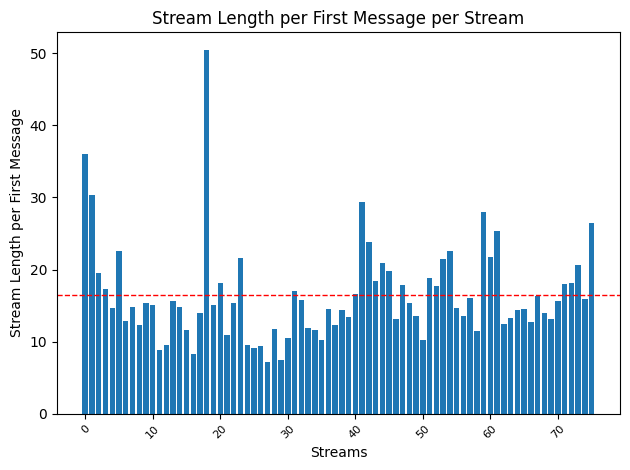

In [55]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for stream_length_per_first
ax.bar(stream_stats.index, stream_stats['stream_length_per_firt'])

# Calculate mean of first messages
mean_stream_length_per_firt = stream_stats['stream_length_per_firt'].mean()

# Draw the mean line
ax.axhline(mean_stream_length_per_firt, color='r', linestyle='--', linewidth=1, label=f'Mean ({mean_stream_length_per_firt:.2f})')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('Stream Length per First Message', fontsize=10)
ax.set_title('Stream Length per First Message per Stream', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

In [56]:
stream_stats['stream_length_per_firt'].describe()

count    76.000000
mean     16.407539
std       6.765709
min       7.228916
25%      12.435608
50%      14.921256
75%      18.187578
max      50.390310
Name: stream_length_per_firt, dtype: float64

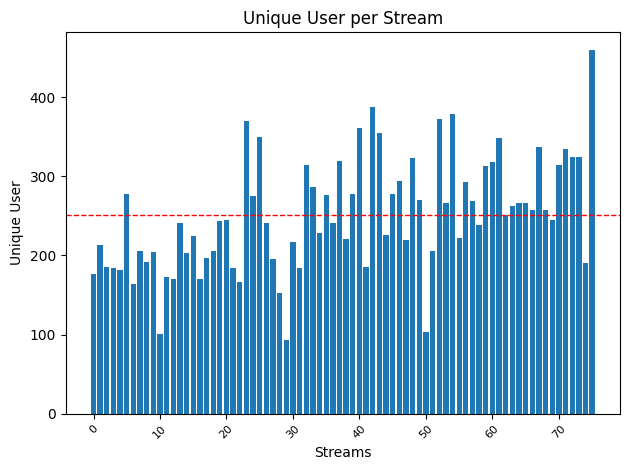

In [57]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for stream_length_per_first
ax.bar(stream_stats.index, stream_stats['unique_chatters'])

# Calculate mean of first messages
mean_stream_unique = stream_stats['unique_chatters'].mean()

# Draw the mean line
ax.axhline(mean_stream_unique, color='r', linestyle='--', linewidth=1, label=f'Mean ({mean_stream_unique:.2f})')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('Unique User', fontsize=10)
ax.set_title('Unique User per Stream', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

In [58]:
stream_stats['unique_chatters_per_hour'] = stream_stats['unique_chatters'] / stream_stats['stream_length_hour']

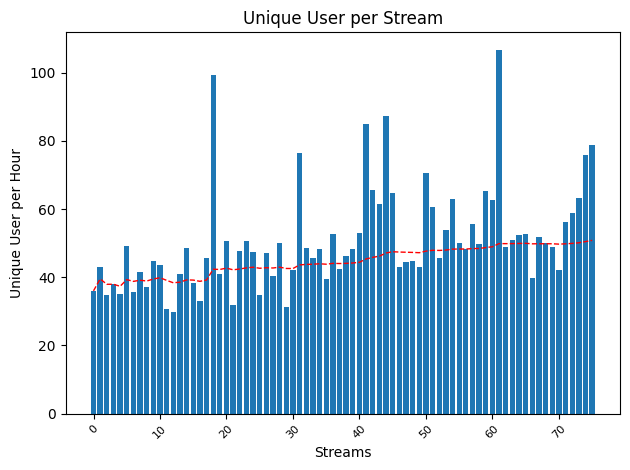

In [61]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for stream_length_per_first
ax.bar(stream_stats.index, stream_stats['unique_chatters_per_hour'])

# Calculate mean of first messages
stream_stats['unique_chatters_per_hour_avg'] = stream_stats['unique_chatters_per_hour'].expanding().mean()

# Plot the running mean line
ax.plot(index, stream_stats['unique_chatters_per_hour_avg'], color='r', linestyle='--', linewidth=1, label='Running Mean')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('Unique User per Hour', fontsize=10)
ax.set_title('Unique User per Stream', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()